**ANÁLISE DE TENDÊNCIAS EM DADOS DE BUSCA DE APLICATIVOS USANDO ALGORITMOS DE APRENDIZADO NÃO SUPERVISIONADO**



---



Trabalho final da disciplina de IMD3003 – APRENDIZADO DE MÁQUINA NÃO-SUPERVISIONADO 2025.2


Este trabalho baseia-se no modelo desenvolvido pelo iFood e comentado pelo CEO da empresa durante um podcast (https://youtu.be/U6BJDHQMgmI?si=BpgWXIOEIdJtcI7Z). O modelo é capaz de identificar tendências com base nas buscas realizadas pelos usuários na plataforma. Além do texto pesquisado, o horário da pesquisa e a região são utilizados para identificar tendências de consumo e com base nesses indicadores é selecionado restaurantes capazes de atender a essa demanda latente que até então pode não ser identificada por eles, além disso é possível também com os resultados realizar a recomendação com base no que é tendências dentro da plataforma. Portanto, o trabalho tem como objetivo desenvolver uma solução utilizando algoritmos de aprendizado não-supervisionado como K Means, Agglomerative Clustering e Embeddings.

In [45]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sentence_transformers import SentenceTransformer

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name, device=device)

file_path = "restaurants.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ahmedshahriarsakib/uber-eats-usa-restaurants-menus",
  file_path,
)

df.head()

Using Colab cache for faster access to the 'uber-eats-usa-restaurants-menus' dataset.


,id,position,name,score,ratings,category,price_range,full_address,zip_code,lat,lng
0,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",$,"224 Daniel Payne Drive, Birmingham, AL, 35207",35207,33.562365,-86.830703
1,2,9,J' ti`'z Smoothie-N-Coffee Bar,NaN,NaN,"Coffee and Tea, Breakfast and Brunch, Bubble Tea",NaN,"1521 Pinson Valley Parkway, Birmingham, AL, 35217",35217,33.583640,-86.773330
2,3,6,Philly Fresh Cheesesteaks (541-B Graymont Ave),NaN,NaN,"American, Cheesesteak, Sandwiches, Alcohol",$,"541-B Graymont Ave, Birmingham, AL, 35204",35204,33.509800,-86.854640
3,4,17,Papa Murphy's (1580 Montgomery Highway),NaN,NaN,Pizza,$,"1580 Montgomery Highway, Hoover, AL, 35226",35226,33.404439,-86.806614
4,5,162,Nelson Brothers Cafe (17th St N),4.7,22.0,"Breakfast and Brunch, Burgers, Sandwiches",NaN,"314 17th St N, Birmingham, AL, 35203",35203,33.514730,-86.811700


In [46]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

'''Função utilizada para remover stopwords, processo importante para melhoria dos resultados'''
def clean_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]   # mantém apenas palavras
    tokens = [t for t in tokens if t not in stop_words]  # remove stopwords
    tokens = ' '.join(tokens)
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# AJUSTANDO AS FEATURES DE INTERESSE

In [47]:
df['price_range'] = df['price_range'].fillna('unknown')
df['price_range'] = df['price_range'].replace('$$$$$$$$$$$$$$$$$','$$$$')
df['price_range'].value_counts()

,count
price_range,
$,37637
$$,14952
unknown,10617
$$$,237
$$$$,26


In [48]:
df['category'] = df['category'].fillna('unknown')

df["category"] = df["category"].str.strip()
df['category'] = df['category'].str.lower()
df['category'] = df['category'].apply(clean_text)

#dataframe com as features de interesse
df_filtered = df[['name','category','price_range','lat','lng']].copy()

- Informações do primeiro conjunto de dados

In [49]:
df_filtered.describe()

,lat,lng
count,63469.000000,63469.000000
mean,36.585019,-96.715114
std,6.458959,14.438166
min,0.000000,-123.841240
25%,30.442221,-98.569760
50%,34.707265,-96.764330
75%,40.884903,-87.938729
max,48.963950,0.000000


- Gerando embedding do primeiro dataset

In [51]:
sentence_embeddings = model.encode(df_filtered['category'].tolist())
df_filtered['embedding'] = list(sentence_embeddings)
print(f"Shape da matriz de embeddings: {sentence_embeddings.shape}")

Shape da matriz de embeddings: (63469, 384)


### AJUSTANDO O SEGUNDO DATA SET E CRIANDO NOVAS FEATURES

- Esse conjunto de dados faz referências aos termos pesquisados por usuários em um aplicativo de comida, junto com essa informação vem a localização de onde o usuário fez a pesquisa e a data e hora.

In [52]:
#from google.colab import drive
#drive.mount('/content/drive')

df_search = pd.read_csv('search_terms_updated_strong.csv') #pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aprendizado de máquina não-supervisionado/Projeto Final/search_terms_updated_strong.csv')
df_search.head()

,search_term,datetime,lat,lng
0,Indian curry with naan,2025-11-19 12:15:24,28.847521,-92.417281
1,Best cheeseburger and fries,2025-11-06 18:32:04,30.342602,-95.127885
2,Lunch special near me,2025-11-11 12:05:07,32.482869,-89.921319
3,Pizza delivery,2025-11-09 20:38:39,30.982236,-93.208197
4,top Indian curry with naan places,2025-11-17 19:40:43,30.630046,-90.490190


In [53]:
'''Função utilizada para identificar qual o período do dia a pesquisa foi realizada'''
def periodo_do_dia(hora):
    h = hora.hour
    if h < 10:
        return 'breakfast'
    elif h < 15:
        return 'lunch'
    else:
        return 'dinner'

In [54]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler

encoder = OneHotEncoder()
scaler = StandardScaler()

#criando novas features
df_search[['data','hora']] = df_search['datetime'].str.split(' ',expand=True)

df_search['data'] = pd.to_datetime(df_search['data'])
df_search['hora'] = pd.to_datetime(df_search['hora'],format='%H:%M:%S',errors='coerce').dt.time

df_search['period'] = df_search['hora'].apply(periodo_do_dia)

#removendo stopwords
df_search['search_term'] = df_search['search_term'].str.lower()
df_search['search_term'] = df_search['search_term'].apply(clean_text)

#normalizando
encoder.fit(df_search[['period']])
period_encoded = encoder.transform(df_search[['period']]).toarray()
period_encoded_df = pd.DataFrame(period_encoded, columns=encoder.get_feature_names_out(['period']))
df_search = pd.concat([df_search, period_encoded_df], axis=1)

scaler.fit(df_search[['lat','lng']])
df_search[['lat','lng']] = scaler.transform(df_search[['lat','lng']])

scaler.fit(df_filtered[['lat','lng']])
df_filtered[['lat','lng']] = scaler.transform(df_filtered[['lat','lng']])

<Axes: xlabel='period', ylabel='count'>

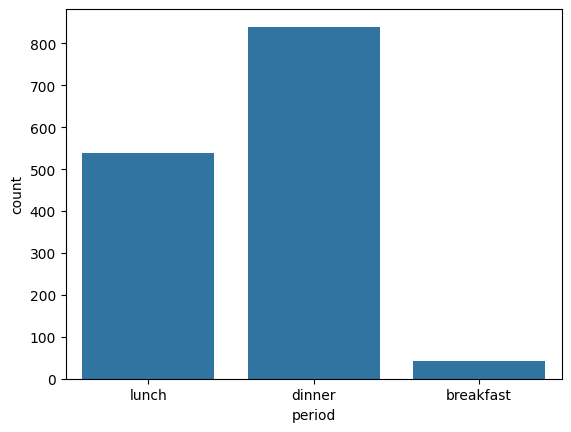

In [55]:
sns.countplot(data=df_search,x='period')

- Gerando embedding dos termos persquisados

In [56]:
sentence_embeddings = model.encode(df_search['search_term'])
print(f"Shape da matriz de embeddings: {sentence_embeddings.shape}")
df_search['embedding'] = list(sentence_embeddings)

Shape da matriz de embeddings: (1421, 384)


### DIVIDIR O CONJUNTO DE DADOS PARA ANÁLISE CADA PERÍODO DE FORMA SEPARADA.

In [57]:
temp_df_search = df_search.loc[:, ~df_search.columns.duplicated()]

df_breakfast = temp_df_search[temp_df_search["period_breakfast"] == 1].copy()
df_lunch = temp_df_search[temp_df_search["period_lunch"] == 1].copy()
df_dinner = temp_df_search[temp_df_search["period_dinner"] == 1].copy()

In [58]:
X_breakfast = np.hstack((df_breakfast[['lat', 'lng']].values,np.vstack(df_breakfast['embedding'].values)))
X_lunch = np.hstack((df_lunch[['lat', 'lng']].values,np.vstack(df_lunch['embedding'].values)))
X_dinner = np.hstack((df_dinner[['lat', 'lng']].values,np.vstack(df_dinner['embedding'].values)))

## IDENTIFICANDO O K ÓTIMO POR MEIO DO MÉTODO DO COTOVELO.

In [59]:
from sklearn.cluster import KMeans

def plot_elbow(X, periodo):
  k_range = range(1, 11)
  inertias = []

  for k in k_range:
    model = KMeans(n_clusters=k, max_iter=150, random_state=42, n_init=10)
    model.fit(X)
    inertias.append(model.inertia_)

  # Plotar o gráfico do cotovelo
  plt.figure(figsize=(10, 6))
  plt.plot(k_range, inertias, 'bo-')
  plt.xlabel('Número de Clusters (K)')
  plt.ylabel('Inércia (WCSS)')
  plt.title(f'Método do Cotovelo para Encontrar o K Ótimo {periodo}')
  plt.xticks(k_range)
  plt.grid(True)
  plt.show()

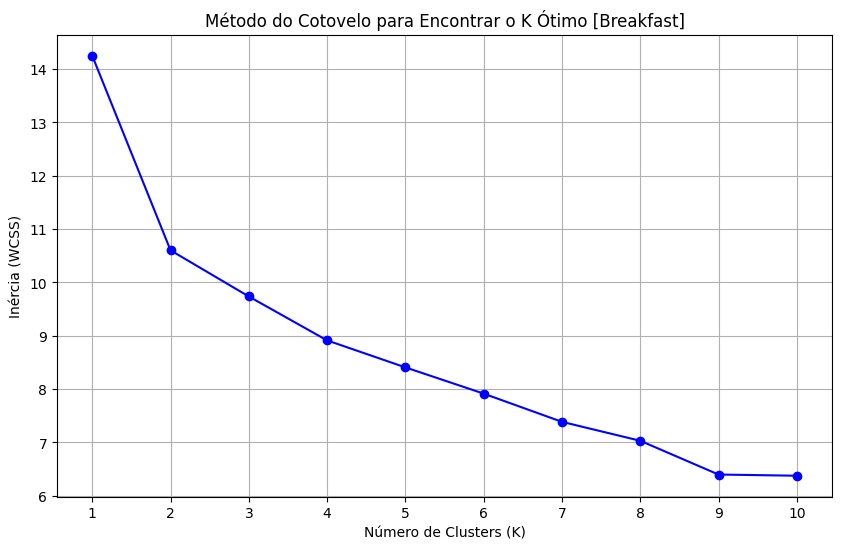

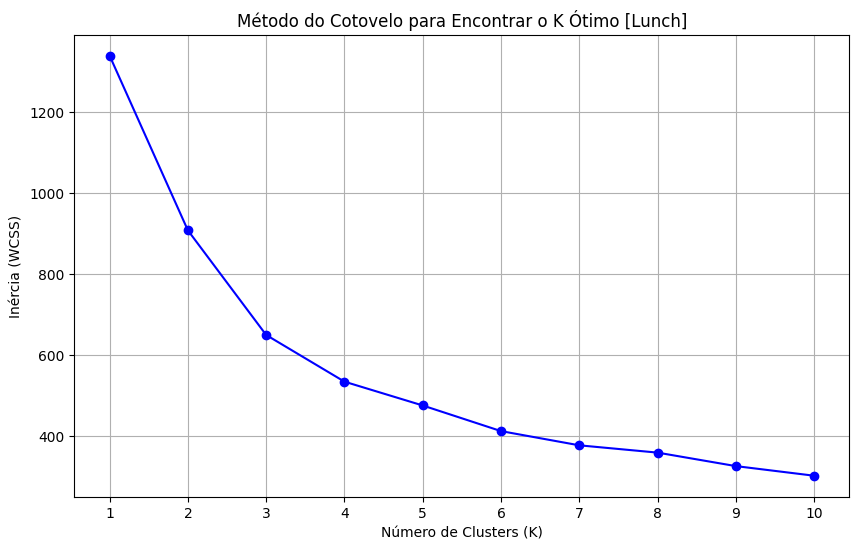

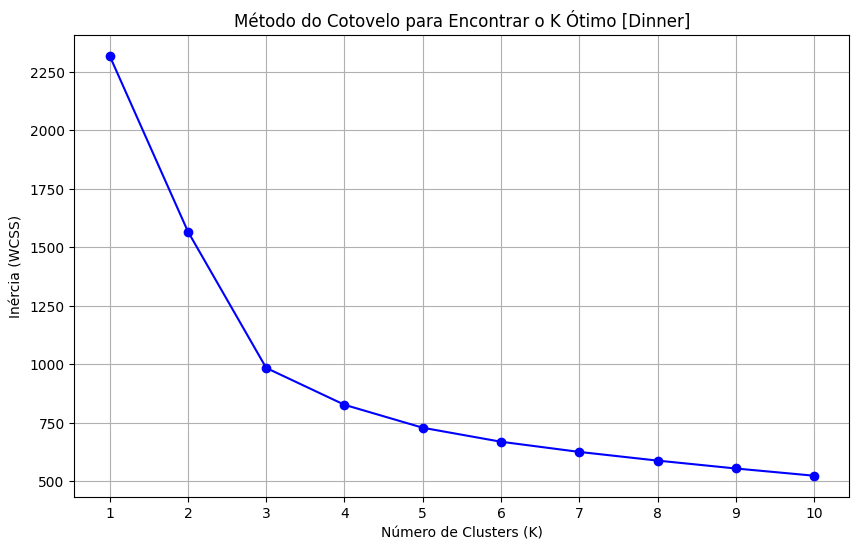

In [25]:
plot_elbow(X_breakfast,'[Breakfast]')
plot_elbow(X_lunch,'[Lunch]')
plot_elbow(X_dinner,'[Dinner]')

# APLICANDO HIERARQUICAL CLUSTERING PARA IDENTIFICAR AJUDAR NA IDENTIFICAÇÃO DO MELHOR VALOR DE K.

In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogam(X,periodo,cut=0):
  Z = linkage(X, method='ward')

  plt.figure(figsize=(10, 4))
  plt.title(f'Dendogram para {periodo}')
  dendrogram(Z)
  plt.axhline(y=cut, color='red', linestyle='--', label=f'Corte em {cut}')
  plt.show()

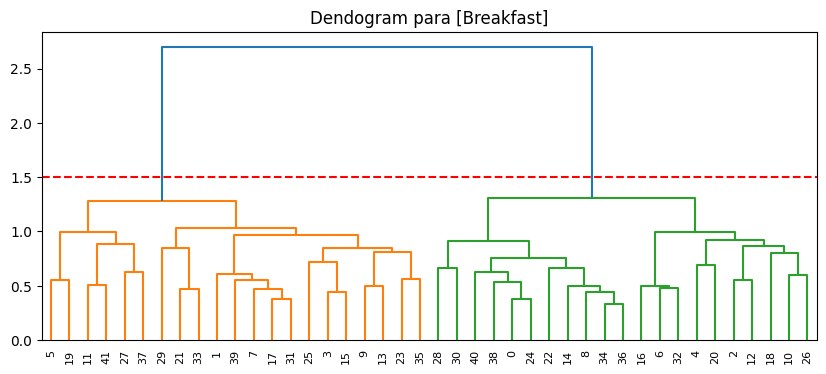

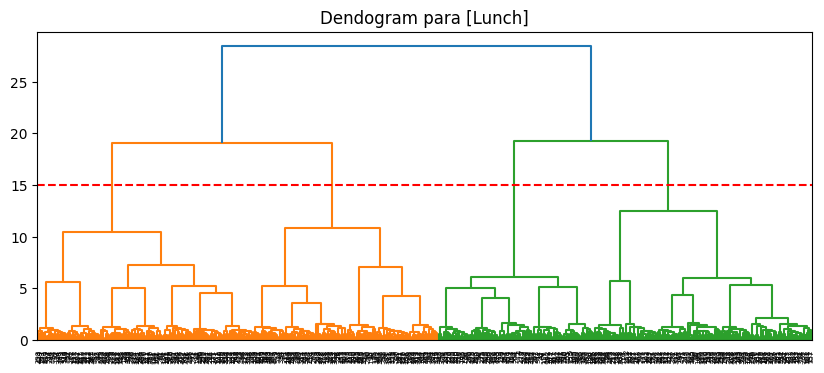

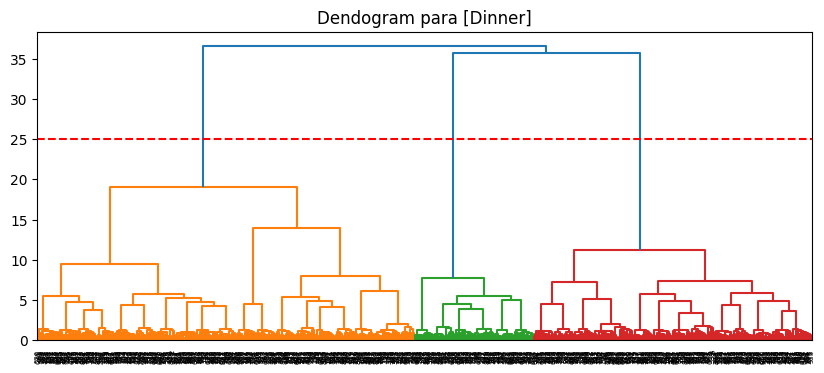

In [68]:
plot_dendrogam(X_breakfast,'[Breakfast]',1.5)
plot_dendrogam(X_lunch, '[Lunch]',15)
plot_dendrogam(X_dinner,'[Dinner]',25)

# FUNÇÕES AUXILIARES QUE AJUDAM A VISUALIZAR OS CLUSTERS

In [60]:
import re
from collections import Counter
from wordcloud import WordCloud

def plot_map(df):
  plt.figure(figsize=(8,6))
  plt.scatter(
      df['lat'],
      df['lng'],
      c=df['cluster'],
      s=100,
      alpha=0.9
  )

  plt.xlabel("Latitude")
  plt.ylabel("Longitude")
  plt.title("Clusters - Scatter Plot")
  plt.show()

def cluster_info(df, num_clusters):
  for i in range(num_clusters):
    df_result = df[df['cluster'] == i].copy()

    text = " ".join(df_result['search_term'].astype(str).tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster: {i}")
    plt.show()

    print('-'*50)

  plot_map(df)

def restaurant_search(df_restaurants_filtered,kmeans):

    restaurants = np.hstack((df_restaurants_filtered[['lat', 'lng']].values,np.vstack(df_restaurants_filtered['embedding'].values)))

    #gera uma matriz com a distancia do X para cada um dos centroides
    distances = kmeans.transform(restaurants)

    #calcula probabilidade aproximada
    inv = 1 / (distances + 1e-9)
    probs = inv / inv.sum(axis=1, keepdims=True)
    labels = np.argmax(probs, axis=1)
    prob = np.max(probs, axis=1)

    df_restaurants_filtered['clusters'] = labels
    df_restaurants_filtered['prob'] = prob

    return df_restaurants_filtered

def rest_recommended(df_rest,n_clusters,top=50):
  for i in range(n_clusters):
    print('-'*50)
    print(f'Restaurantes recomendados para o cluster: {i}')
    print('-'*50)
    display(df_rest[df_rest['clusters'] == i].sort_values('prob', ascending=False).head(top))

# ANÁLISE DOS CLUSTERS DA MANHÃ

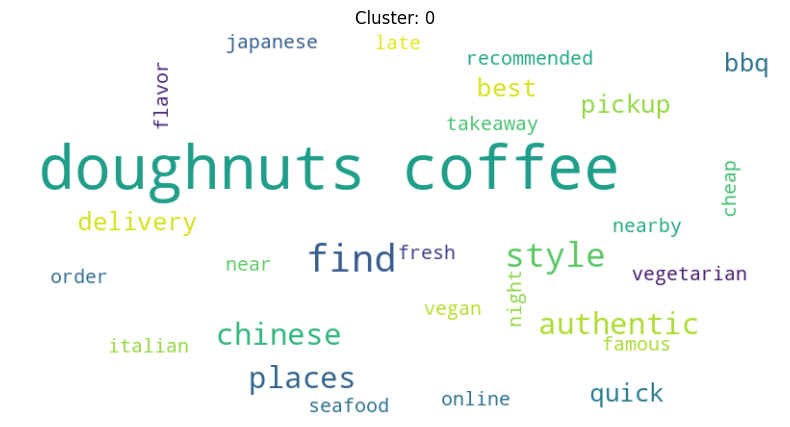

--------------------------------------------------


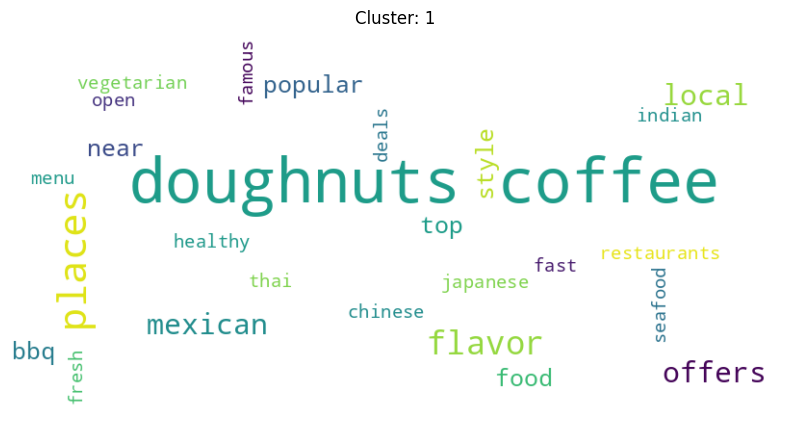

--------------------------------------------------


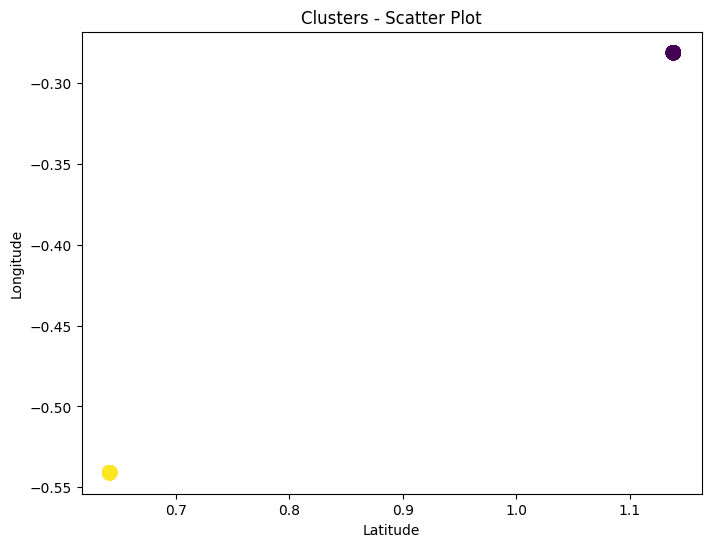

In [61]:
num_k = 2
kmeans = KMeans(n_clusters=num_k, random_state=42)
kmeans.fit(X_breakfast)
df_breakfast['cluster'] = kmeans.labels_
cluster_info(df_breakfast,num_k)
df_restaurants = restaurant_search(df_filtered,kmeans)

In [62]:
df_rest_recommend = df_restaurants[['name','category','price_range','clusters','prob']].copy()
df_rest_recommend = df_rest_recommend.drop_duplicates()

rest_recommended(df_rest_recommend,num_k,20)

--------------------------------------------------
Restaurantes recomendados para o cluster: 0
--------------------------------------------------


,name,category,price_range,clusters,prob
3625,Starbucks (Central Entrance &amp; Anderson Rd),bakery breakfast brunch cafe coffee amp tea,$,0,0.573743
3606,Dunkin' (3110 Tower Ave),breakfast brunch donuts,$,0,0.572991
3582,Pretzelmaker (1600 Miller Trunk Hwy),fast food bakery desserts,$,0,0.568115
3627,Cold Stone Creamery (1017 W Central Entrance),ice cream frozen yogurt desserts cupcakes,$,0,0.565338
3581,Caribou Coffee (627 West Central Entrance),cafe sandwich,$$,0,0.565230
3634,Cold Stone Creamery (349 Canal Park Drive),ice cream frozen yogurt desserts cupcakes,$,0,0.565225
3635,Caribou Coffee (2100 London Road),cafe sandwich,$$,0,0.565153
3607,Perkins Restaurant &amp; Bakery (103 E 2nd Str...,breakfast brunch american dinner bakery,$$,0,0.564048
4226,Cabin Coffee Co-Rice Lake Wi,coffee tea american breakfast brunch,$$,0,0.563212
5400,Starbucks (Hastings &amp; Kirk),bakery breakfast brunch cafe coffee amp tea,$,0,0.563073


--------------------------------------------------
Restaurantes recomendados para o cluster: 1
--------------------------------------------------


,name,category,price_range,clusters,prob
31179,Daylight Donuts,desserts breakfast brunch coffee tea bakery,$,1,0.572229
31291,Taco Bell (610 East St George Blvd),burritos fast food mexican,$,1,0.571456
32115,Taco Bell (1418 West Sunset Blvd),burritos fast food mexican,$,1,0.571386
32609,Taco Bell (1330 S Providence Center Drive),burritos mexican tacos,$,1,0.570470
31277,Starbucks (W Sunset Blvd &amp; N Bluff St),bakery breakfast brunch cafe coffee amp tea,$,1,0.569992
32568,Starbucks (Providence Crossing- Cedar Cit),bakery breakfast brunch cafe coffee amp tea,$,1,0.569855
31162,Sweet Rolled Tacos,desserts vegetarian coffee tea healthy,$,1,0.569076
31190,Costa Vida (2376 Red Cliffs Dr),mexican new mexican comfort food,$,1,0.568748
31251,El Patron Mexican Food,mexican latin american new mexican tacos burri...,$,1,0.568735
31296,Crumbl Cookies (UT - St. George Bluff),desserts coffee tea,$,1,0.568682


# ANÁLISE DOS CLUSTERS DA TARDE

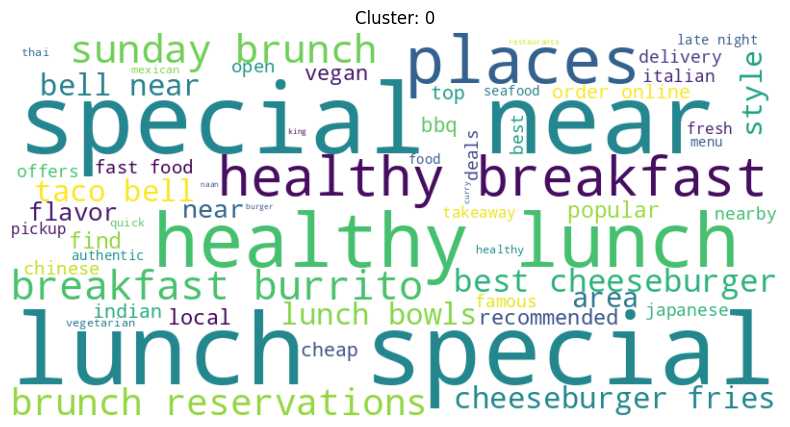

--------------------------------------------------


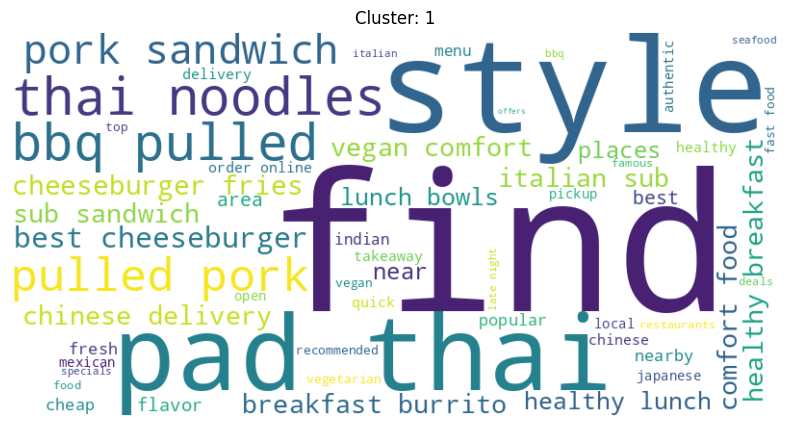

--------------------------------------------------


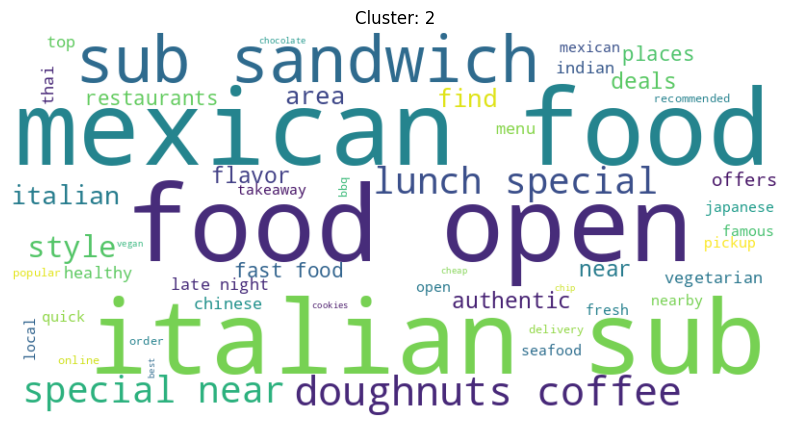

--------------------------------------------------


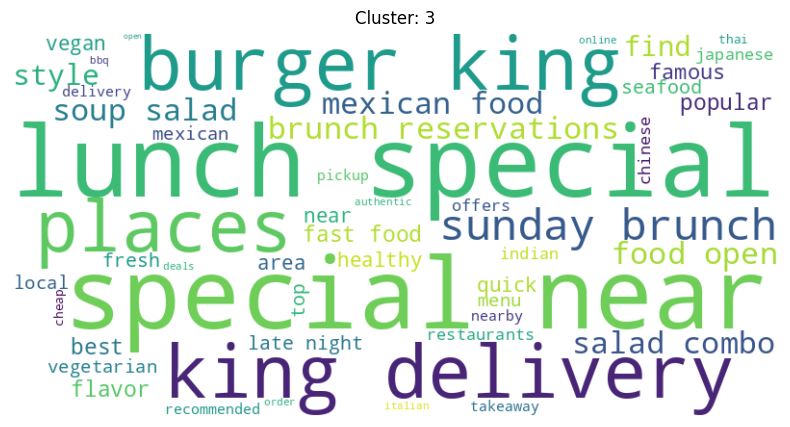

--------------------------------------------------


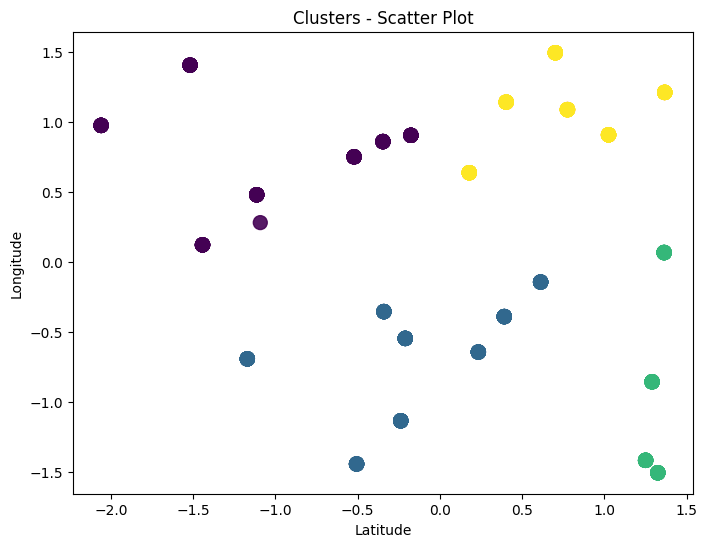

In [63]:
num_k = 4
kmeans = KMeans(n_clusters=num_k, random_state=42)
kmeans.fit(X_lunch)
df_lunch['cluster'] = kmeans.labels_
cluster_info(df_lunch,num_k)
df_restaurants = restaurant_search(df_filtered,kmeans)

In [64]:
df_rest_recommend = df_restaurants[['name','category','price_range','clusters','prob']].copy()
df_rest_recommend = df_rest_recommend.drop_duplicates()

rest_recommended(df_rest_recommend,num_k,20)

--------------------------------------------------
Restaurantes recomendados para o cluster: 0
--------------------------------------------------


,name,category,price_range,clusters,prob
624,Applebee's (Dothan),diner burgers breakfast brunch comfort food pa...,$$,0,0.466474
612,Outback Steakhouse (2925 Ross Clark Circle),burgers american sandwiches steak seafood sala...,$,0,0.463516
1073,Zaxby's (1800 Gulf Shores Pkwy),burgers american sandwiches family meals,$,0,0.463206
599,Denny's (2190 Ross Clark Circle),american breakfast brunch coffee tea dinner de...,$$,0,0.463148
1070,Cracker Barrel Old Country Store (3150 S McKen...,burgers american sandwiches family meals,$,0,0.461532
614,Metro Diner (Dothan),diner breakfast brunch burgers comfort food fa...,$$,0,0.459597
1068,Chick-fil-A (3013 S Mckenzie St),american fried chicken family meals southern s...,$,0,0.458887
1046,A Sweet Secret Bakery &amp; Cafe,american breakfast brunch desserts,$$,0,0.458620
1091,Honey Baked Ham (Foley),sandwich american comfort food family meals,$,0,0.458381
1019,Burger King (1501 Gulf Shores Parkway),american burger fast food family meals,$,0,0.458305


--------------------------------------------------
Restaurantes recomendados para o cluster: 1
--------------------------------------------------


,name,category,price_range,clusters,prob
31301,Black Bear Diner (1245 South Main Street),american burgers comfort food diner breakfast ...,$$,1,0.417509
44798,Thrilled Cheese (7061 S. Desert Blvd.),sandwich new american comfort food,unknown,1,0.417033
44822,Chicken N' Biscuits by Cracker Barrel (7540 Re...,american comfort food fried chicken family mea...,$$,1,0.416904
44823,Pei Wei (7500 N Mesa St. Suite 101),chicken salads asian chinese asian fusion thai...,$$,1,0.416796
31261,Black Bear Diner (965 Hoodoo Way),american burgers comfort food steak chicken di...,$$,1,0.416709
44824,Chick-fil-A (10721 Gateway South Blvd.),american fried chicken family meals southern s...,$,1,0.416524
44757,Charleys Cheesesteaks - Outlet Shoppes at El P...,sandwich american comfort food,$,1,0.416327
31215,Chick-fil-A (15 S River Rd Ste 500),american fried chicken family meals southern s...,$,1,0.416253
55443,Ciros Bar &amp; Kitchen,mexican seafood burgers,$$,1,0.416155
44794,Chili's (7600 N. Mesa),american burgers salads family meals healthy c...,$$,1,0.416018


--------------------------------------------------
Restaurantes recomendados para o cluster: 2
--------------------------------------------------


,name,category,price_range,clusters,prob
16410,Taco Bell (1429 S Blaine St),burritos fast food mexican,$,2,0.485429
17161,Taco Bell (450 Bridge St),burritos fast food mexican,$,2,0.485268
16027,Taco Bell (425 NE STADIUM WAY),burritos fast food mexican,$,2,0.484374
16725,Taco Bell (22312 E Appleway),burritos fast food mexican,$,2,0.480989
14437,Taco Bell (10620 East Sprague Avenue),burritos fast food mexican,$,2,0.480307
16512,Taco Bell (2626 First Street),burritos fast food mexican,$,2,0.479608
16516,Taco Bell (825 W 3rd Ave),burritos fast food mexican,$,2,0.479512
14444,Taco Bell (6614 N Division St),burritos fast food mexican,$,2,0.479192
14547,Taco Bell (6404 N Ash St),burritos fast food mexican,$,2,0.479074
16535,Taco Bell (9664 N Newport Hwy),burritos fast food mexican,$,2,0.479044


--------------------------------------------------
Restaurantes recomendados para o cluster: 3
--------------------------------------------------


,name,category,price_range,clusters,prob
6371,Burger King (4124 Freedom Way),american burger fast food family meals,$,3,0.466952
6451,Sheetz - 6 Cabela Dr (429),american comfort food deli desserts dinner fas...,$,3,0.462767
6447,Sheetz - 25 Gantzer Ridge Road (650),american comfort food deli desserts dinner fas...,$,3,0.462758
6153,Sheetz - 887 National Rd (362),american comfort food deli desserts dinner fas...,$,3,0.462673
6391,Huddle House (4150 Freedom Way),american breakfast amp brunch salads family meals,$,3,0.461298
6145,Perkins Restaurant &amp; Bakery (680 National Rd),burgers american sandwiches family meals,$,3,0.460612
6394,Sheetz - 239 Three Springs Road (234),american comfort food deli desserts dinner fas...,$,3,0.459373
6127,Chipotle Mexican Grill (225 Cabela Drive),mexican salads,$,3,0.458252
6362,Sheetz -1525 Main St (446),american comfort food deli desserts dinner fas...,$,3,0.458158
29261,Shelburne Tap House,burgers salads sandwiches,unknown,3,0.456882


# ANÁLISE DOS CLUSTERS DA NOITE (DINNER)

In [65]:
num_k = 3
kmeans = KMeans(n_clusters=num_k, random_state=42)
kmeans.fit(X_dinner)
df_dinner['cluster'] = kmeans.labels_

- Demanda identificada de acordo com o que os usuários buscam durante o período do jantar

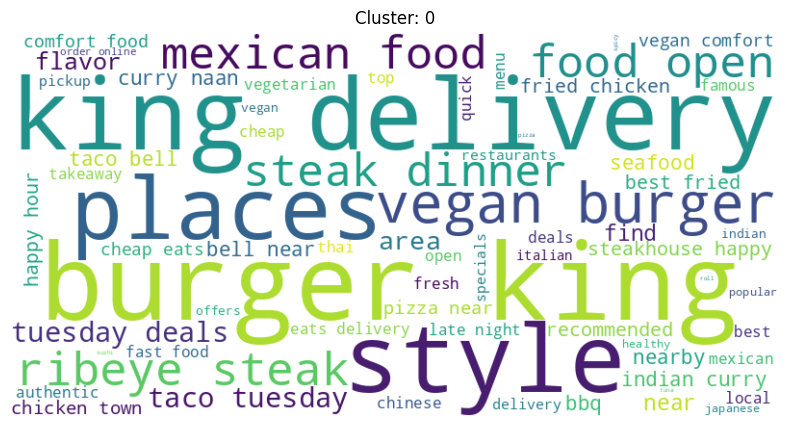

--------------------------------------------------


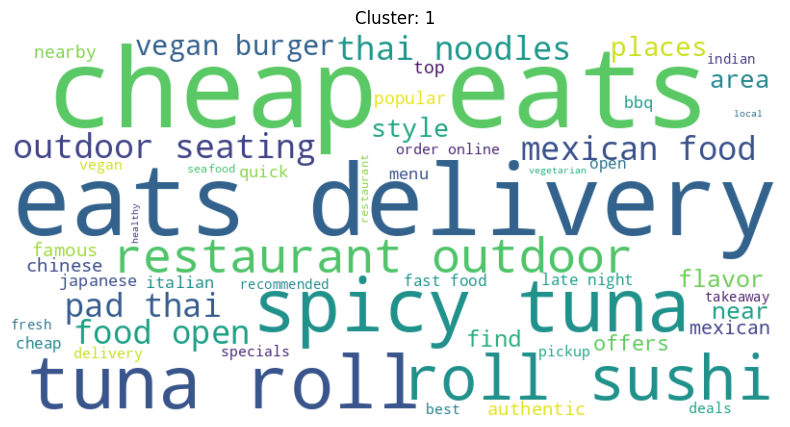

--------------------------------------------------


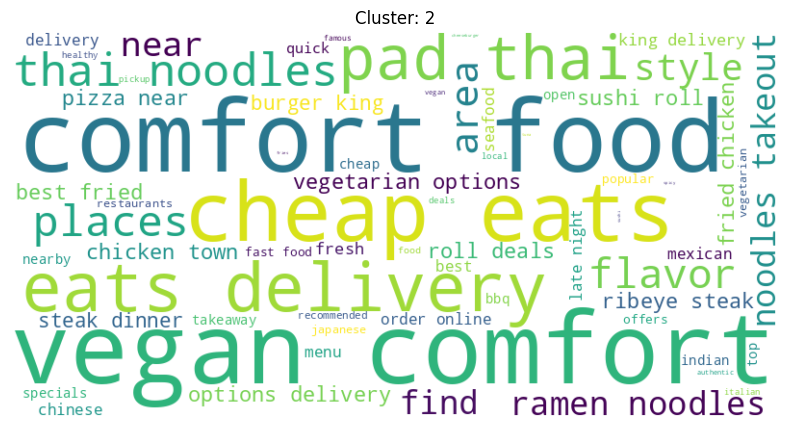

--------------------------------------------------


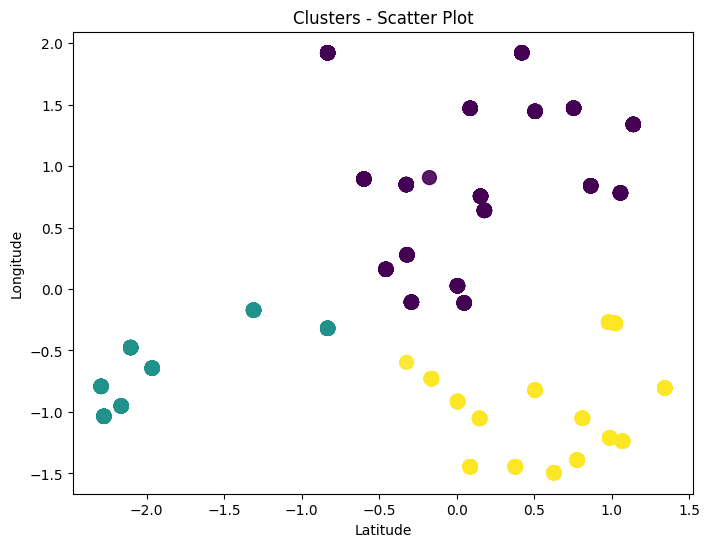

In [66]:
cluster_info(df_dinner,num_k)
df_restaurants = restaurant_search(df_filtered,kmeans)

- Restaurantes identificados que podem atender a demanda acima

In [67]:
df_rest_recommend = df_restaurants[['name','category','price_range','clusters','prob']].copy()
df_rest_recommend = df_rest_recommend.drop_duplicates()

rest_recommended(df_rest_recommend,num_k,20)

--------------------------------------------------
Restaurantes recomendados para o cluster: 0
--------------------------------------------------


,name,category,price_range,clusters,prob
24298,The Burger Den (2039 W Main St),american burgers comfort food vegetarian frien...,$$,0,0.618859
21482,The Burger Den (3429 Orange Ave),american burgers comfort food vegetarian frien...,$$,0,0.618609
24864,Blissful Vegan Grill,vegan vegetarian burgers fast food american diner,unknown,0,0.615771
28106,BJ's Restaurant &amp; Brewhouse (Charlottesvil...,american burgers pizza family meals,$$,0,0.613529
24263,MrBeast Burger (2380 Roanoke Street),american burgers chicken desserts,$$,0,0.613212
6109,MrBeast Burger (151 Coleman Drive),american burgers chicken desserts,$$,0,0.612926
7402,"The Saucy Hen (500 MALL ROAD, SPACE #395)",bbq american chicken pasta burgers,$$,0,0.612775
6873,MrBeast Burger (2082 Harper Road),american burgers chicken desserts,$$,0,0.612691
28435,MrBeast Burger (1355 Boxwood Terrace),american burgers chicken desserts,$$,0,0.612570
17679,MrBeast Burger (145 Commonwealth Avenue),american burgers chicken desserts,$$,0,0.612530


--------------------------------------------------
Restaurantes recomendados para o cluster: 1
--------------------------------------------------


,name,category,price_range,clusters,prob
61251,Palenque Grill (La Plaza Mall),mexican latin american new mexican seafood ste...,$,1,0.543984
57426,"MORI - McAllen, TX",japanese asian sushi family meals,$,1,0.543837
57181,Rebecca's Mexican Restaurant &amp; Catering,mexican seafood salads,unknown,1,0.543673
41773,Cockteleria La Patrona,seafood mexican snacks,unknown,1,0.541678
41892,Palenque Grill (Edinburg),mexican latin american new mexican seafood ste...,$,1,0.541422
57364,Los Villa Taqueria (McColl),mexican tacos burgers,unknown,1,0.541393
57204,Chepuerco Restaurant,mexican latin american new mexican exclusive eats,$,1,0.541371
41762,Woodreaux's Bar &amp; Grill,american burgers sandwiches seafood wings fish...,$$,1,0.540798
57183,Hayashi Hibachi (McAllen),asian japanese seafood sushi family meals,$,1,0.540675
57143,Taco Fiesta 956,burgers mexican tacos,$,1,0.539809


--------------------------------------------------
Restaurantes recomendados para o cluster: 2
--------------------------------------------------


,name,category,price_range,clusters,prob
30504,Enjoy Chinese Cuisine,chinese noodles vegetarian family meals,$,2,0.611259
30401,The Roll Co.,indian vegetarian asian mexican rolls fast foo...,unknown,2,0.607047
30342,The Burger Den (1172 W 2100 St),american burgers comfort food vegetarian frien...,$$,2,0.606651
30165,The Burger Den (1250 Washington Blvd),american burgers comfort food vegetarian frien...,$$,2,0.606571
30327,The Burger Den (4029 Riverdale Rd.),american burgers comfort food vegetarian frien...,$$,2,0.606494
29980,The Burger Den (1701 West N Temple),american burgers comfort food vegetarian frien...,$$,2,0.604615
29603,The Burger Den (250 W 500 S),american burgers comfort food vegetarian frien...,$$,2,0.604413
31659,The Burger Den (925 N Main St),american burgers comfort food vegetarian frien...,$$,2,0.603998
30915,The Burger Den (420 W 4500 S),american burgers comfort food vegetarian frien...,$$,2,0.603875
32005,Sizzler (1165 N Main St),american burgers seafood family meals,$$,2,0.603848
